In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [3]:
spark = SparkSession.builder \
    .appName('NASA_EDA') \
    .config('spark.driver.memory', '4g') \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/02 19:47:25 WARN Utils: Your hostname, MacBook-Air-cua-o-3.local, resolves to a loopback address: 127.0.0.1; using 10.28.253.19 instead (on interface en0)
26/02/02 19:47:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/02 19:47:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/02 19:47:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load Preprocessed Data

In [ ]:
train_5m_spark = spark.read.csv('../data/train_5m_autoscaling.csv', header=True, inferSchema=True)
train_5m = train_5m_spark.toPandas()
train_5m['timestamp'] = pd.to_datetime(train_5m['timestamp'])
train_5m = train_5m.sort_values('timestamp').reset_index(drop=True)

print(f"Shape: {train_5m.shape}")
print(f"Columns: {train_5m.columns.tolist()}")
train_5m.head()

Shape: (15132, 16)
Columns: ['timestamp', 'requests_count', 'log_requests', 'is_burst', 'burst_ratio', 'is_event', 'hour_of_day', 'day_of_week', 'hour_sin', 'hour_cos', 'lag_requests_5m', 'lag_requests_15m', 'rolling_max_1h', 'rolling_mean_1h', 'lag_requests_6h', 'lag_requests_1d']


,timestamp,requests_count,log_requests,is_burst,burst_ratio,is_event,hour_of_day,day_of_week,hour_sin,hour_cos,lag_requests_5m,lag_requests_15m,rolling_max_1h,rolling_mean_1h,lag_requests_6h,lag_requests_1d
0,1995-07-01 11:00:00,301,5.710427,0,NaN,0,11,5,0.258819,-0.965926,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-07-01 11:05:00,267,5.590987,0,1.000000,0,11,5,0.258819,-0.965926,301.0,NaN,301.0,301.0,NaN,NaN
2,1995-07-01 11:10:00,242,5.493061,0,0.940141,0,11,5,0.258819,-0.965926,267.0,NaN,301.0,284.0,NaN,NaN
3,1995-07-01 11:15:00,282,5.645447,0,0.896296,0,11,5,0.258819,-0.965926,242.0,301.0,301.0,270.0,NaN,NaN
4,1995-07-01 11:20:00,318,5.765191,0,1.032967,0,11,5,0.258819,-0.965926,282.0,267.0,301.0,273.0,NaN,NaN


## Define Constants

In [5]:
INSTANCE_CAPACITY = 200
storm_start = pd.Timestamp('1995-08-01')
storm_end = pd.Timestamp('1995-08-03')

## Time Series Analysis with Seasonal Decomposition

In [6]:
df_missing = train_5m[['timestamp', 'requests_count', 'is_event', 'is_burst']].copy()
df_missing.set_index('timestamp', inplace=True)

zero_mask = (df_missing['requests_count'] == 0)
groups = (zero_mask != zero_mask.shift()).cumsum()
consecutive_counts = zero_mask.groupby(groups).transform('sum')

df_missing['request_interp'] = df_missing['requests_count'].copy()
df_missing.loc[zero_mask & (consecutive_counts >= 288), 'request_interp'] = np.nan
df_missing.loc[df_missing['is_event'] == 1, 'request_interp'] = np.nan
df_missing.loc[df_missing['is_burst'] == 1, 'request_interp'] = np.nan

for lag in [288, 2016]:
    df_missing['request_interp'] = df_missing['request_interp'].fillna(
        df_missing['request_interp'].shift(lag)
    )
df_missing['request_interp'] = df_missing['request_interp'].interpolate(method='time')

mstl_model = MSTL(df_missing['request_interp'].dropna(), periods=(288, 2016))
result_mstl = mstl_model.fit()

trend_comp = result_mstl.trend
seasonal_daily_comp = result_mstl.seasonal.iloc[:, 0]
seasonal_weekly_comp = result_mstl.seasonal.iloc[:, 1]
residual_comp = result_mstl.resid

### 1. Original vs Interpolated

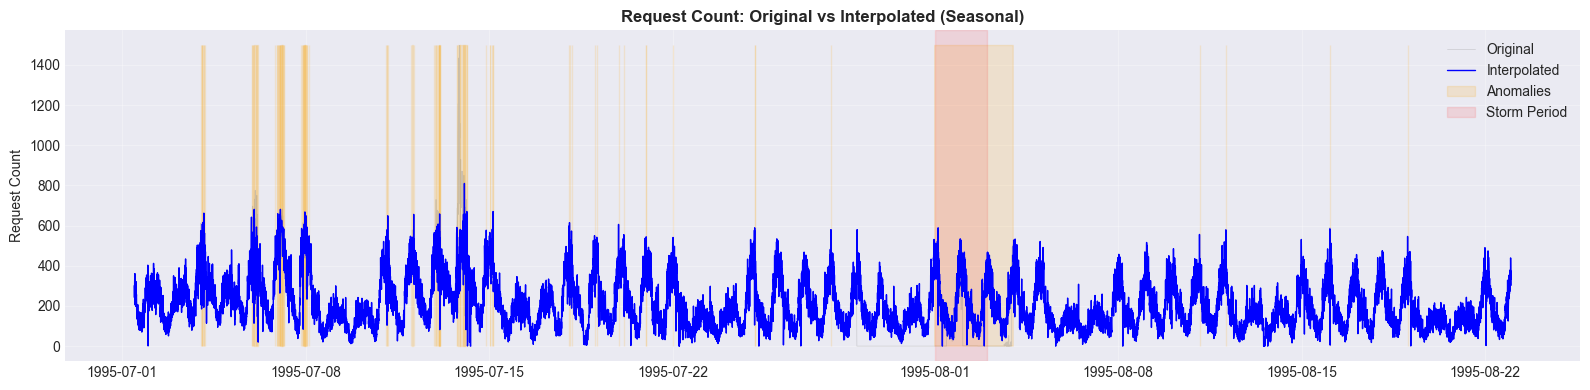

In [7]:
fig1, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df_missing.index, df_missing['requests_count'], color='gray', alpha=0.3, linewidth=0.5, label='Original')
ax1.plot(df_missing.index, df_missing['request_interp'], color='blue', linewidth=1.0, label='Interpolated')
ax1.fill_between(df_missing.index, 0, df_missing['requests_count'].max(), 
                  where=(df_missing['is_event']==1)|(df_missing['is_burst']==1), 
                  alpha=0.15, color='orange', label='Anomalies')
ax1.axvspan(storm_start, storm_end, alpha=0.1, color='red', label='Storm Period')
ax1.set_ylabel('Request Count')
ax1.set_title('Request Count: Original vs Interpolated (Seasonal)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2. Trend Component

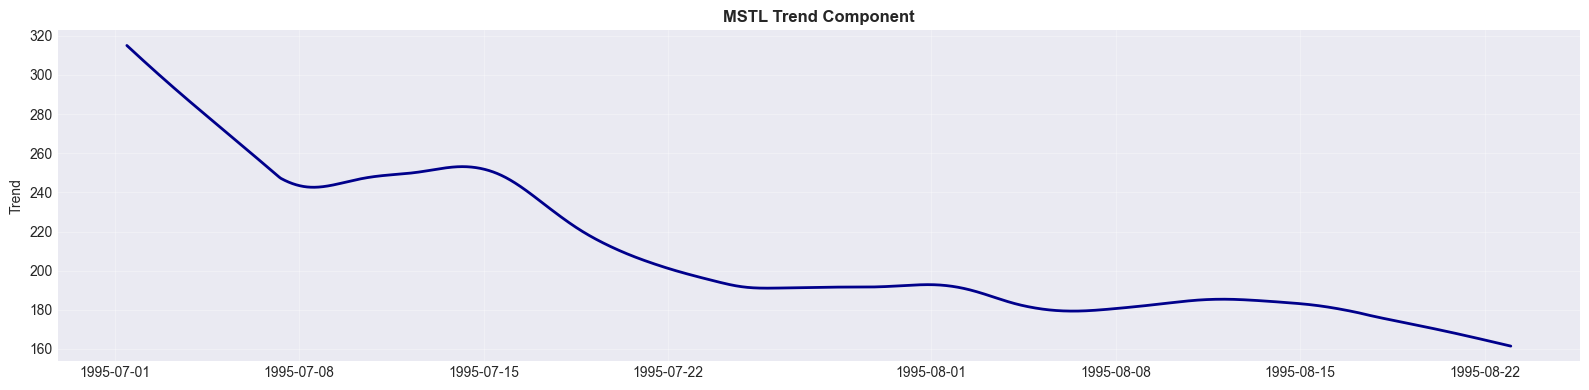

In [8]:
fig2, ax2 = plt.subplots(figsize=(16, 4))
ax2.plot(trend_comp.index, trend_comp.values, color='darkblue', linewidth=2)
ax2.set_ylabel('Trend')
ax2.set_title('MSTL Trend Component', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Daily Seasonality

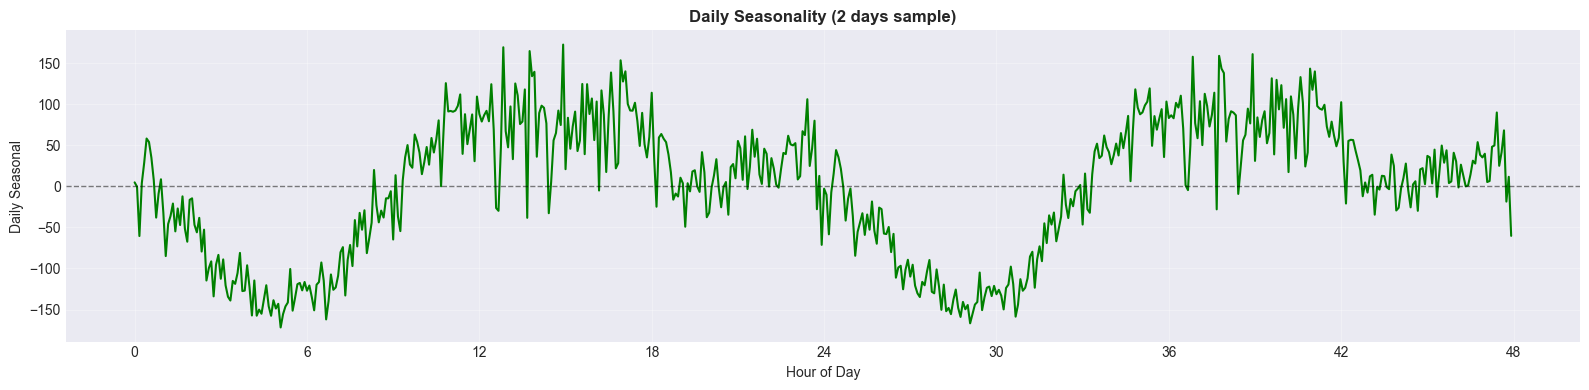

In [9]:
fig3, ax3 = plt.subplots(figsize=(16, 4))
daily_sample = seasonal_daily_comp[:288*2]
hours = np.arange(len(daily_sample)) / 12
ax3.plot(hours, daily_sample.values, color='green', linewidth=1.5)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_ylabel('Daily Seasonal')
ax3.set_xlabel('Hour of Day')
ax3.set_title('Daily Seasonality (2 days sample)', fontsize=12, fontweight='bold')
ax3.set_xticks(range(0, 49, 6))
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. Weekly Seasonality

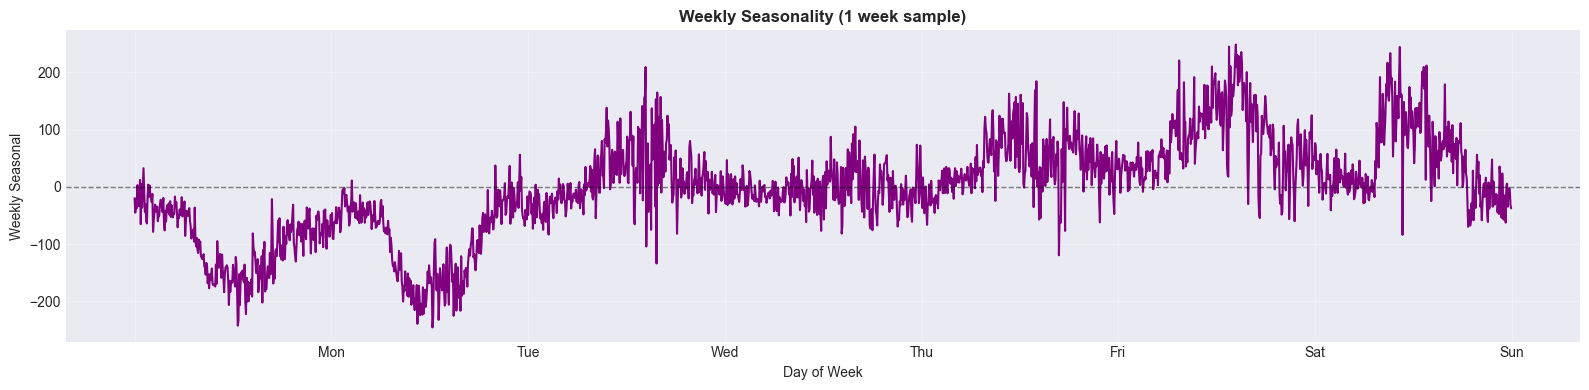

In [10]:
fig4, ax4 = plt.subplots(figsize=(16, 4))
weekly_sample = seasonal_weekly_comp[:2016]
days = np.arange(len(weekly_sample)) / 288
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax4.plot(days, weekly_sample.values, color='purple', linewidth=1.5)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_ylabel('Weekly Seasonal')
ax4.set_xlabel('Day of Week')
ax4.set_title('Weekly Seasonality (1 week sample)', fontsize=12, fontweight='bold')
ax4.set_xticks(range(8))
ax4.set_xticklabels([''] + day_labels)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5. Residuals

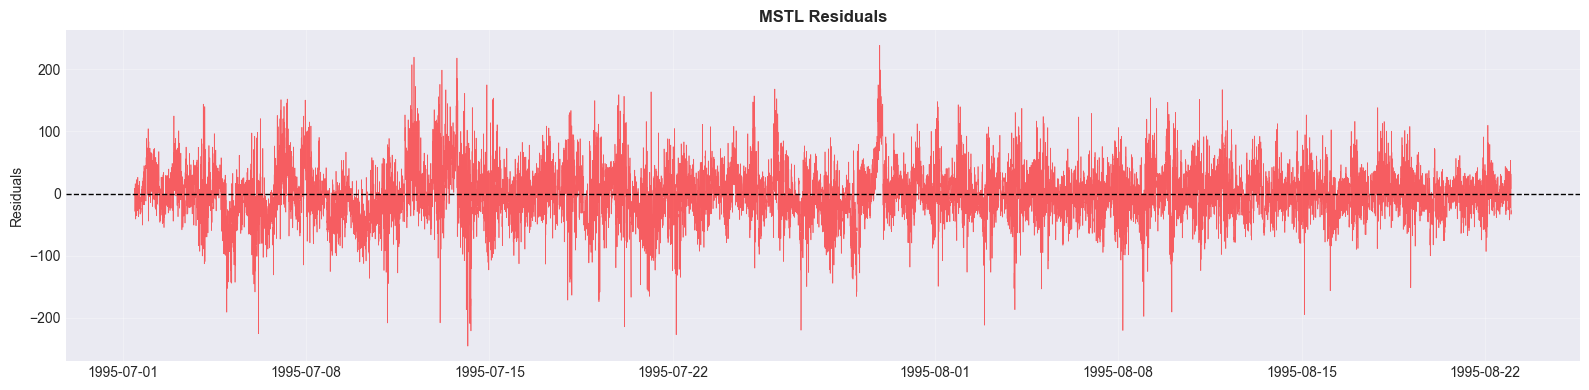

In [11]:
fig5, ax5 = plt.subplots(figsize=(16, 4))
ax5.plot(residual_comp.index, residual_comp.values, color='red', alpha=0.6, linewidth=0.5)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_ylabel('Residuals')
ax5.set_title('MSTL Residuals', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6. Zoom-in View

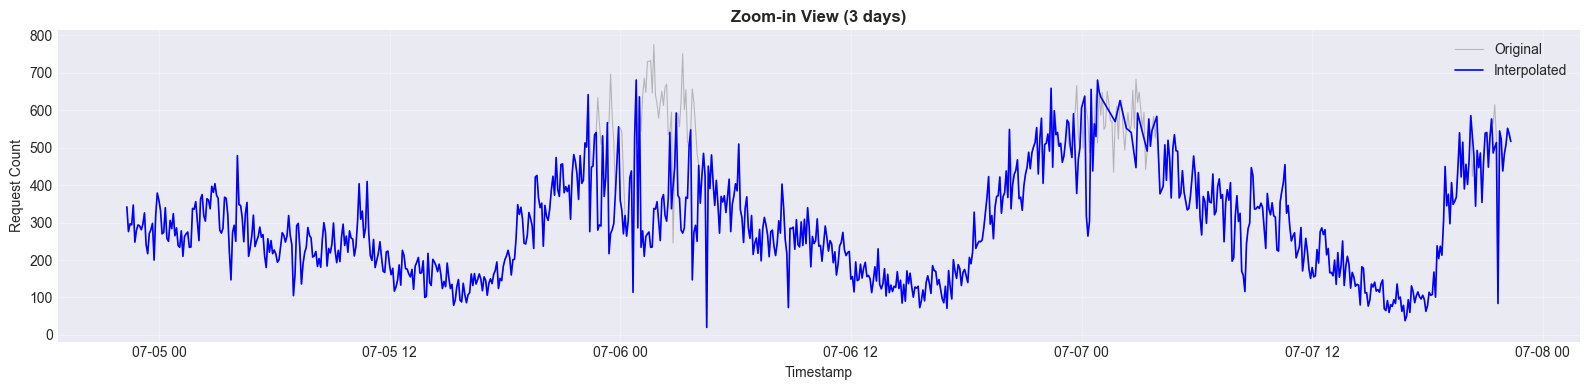

In [12]:
fig6, ax6 = plt.subplots(figsize=(16, 4))
zoom_start = df_missing.index[1000]
zoom_end = df_missing.index[1000 + 288*3]
zoom_mask = (df_missing.index >= zoom_start) & (df_missing.index <= zoom_end)
ax6.plot(df_missing.index[zoom_mask], df_missing['requests_count'][zoom_mask], 
         color='gray', alpha=0.5, linewidth=0.8, label='Original')
ax6.plot(df_missing.index[zoom_mask], df_missing['request_interp'][zoom_mask], 
         color='blue', linewidth=1.2, label='Interpolated')
ax6.set_ylabel('Request Count')
ax6.set_xlabel('Timestamp')
ax6.set_title('Zoom-in View (3 days)', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()